In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt, ceil

sns.set_theme()

## Temporal Modelling (ARIMA)
In this notebook we apply an ARIMA model to the 3 datasets, and attempt to predict the last 30 days in the dataset. 
First we define the fitting and plotting functions we will use for all datasets. We utilize the pmdarima package for fitting and forecasting, and Seaborn for plotting the results.

In [61]:
def autoARIMAfunc(df):
    
    # Training data split
    train_df = df.iloc[:-30]  
    test_df = df.iloc[-30:]
    
    # define output dataframes
    forecast_df = pd.DataFrame(index = test_df.index)
    upper_df = pd.DataFrame(index = test_df.index)
    lower_df = pd.DataFrame(index = test_df.index)
    fit_df = pd.DataFrame(index = train_df.index)
    
    columns = df.columns
    for col in columns[1:]:
        # apply auto_arima. will estimate the pdq x PDQ model paramenters
        model = pm.auto_arima(train_df[col], seasonal=True, start_p=0, start_q=0, max_p=10, max_q=10, trace=True)
        # generate forecast and confidence intervals
        forecast, confidenceInt = model.predict(30, return_conf_int=True)
        forecast_df[col] = forecast
        lower_df[col] = confidenceInt[:,0]
        upper_df[col] = confidenceInt[:,1]
        fit_df[col] = model.fittedvalues()
        
    return train_df, test_df, fit_df, forecast_df, lower_df, upper_df
    

In [62]:
def plotARIMAfunc(train_df, test_df, fit_df, forecast_df, lower_df, upper_df):   
    columns = train_df.columns
    k = ceil(len(columns)/2)
    fig, axs = plt.subplots(nrows=k, ncols=2, figsize=(30, k*5))
    i = 0
    j = 0
    palette = sns.color_palette()
    for col in columns[1:]:
        # Plot data and fitted model
        sns.lineplot(x = train_df.timestamp.iloc[-300:], y = train_df[col].iloc[-300:], ax=axs[i,j], color=palette[0], label="Actual")
        sns.lineplot(x = train_df.timestamp.iloc[-300:], y = fit_df[col].iloc[-300:], ax=axs[i,j], color=palette[1], label="Forecast")
        sns.lineplot(x = test_df.timestamp, y = test_df[col], ax=axs[i,j], color=palette[0])
        sns.lineplot(x = test_df.timestamp, y = forecast_df[col], ax=axs[i,j], color=palette[1])
        # plot confidence interval
        axs[i,j].fill_between(test_df.timestamp, lower_df[col], upper_df[col], alpha=0.2)
        
        # print RMSE, and add legend and labels
        rmse = sqrt(mean_squared_error(test_df[col], forecast_df[col]))
        print(f'RMSE for {col} Stations: {rmse}')
        axs[i,j].set_title(col + f", Forecast RMSE: {rmse}")
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('Energy (kWh)')
        axs[i,j].legend(loc='upper left')
        
        j += 1
        if j >= 2:
            i += 1
            j = 0
            
    plt.show()

## Palo Alto

In [57]:
PA_data = pd.read_csv('data/EVChargingStationUsage.csv')

C:\Users\pgsva\AppData\Local\Temp\ipykernel_15248\1309580590.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  PA_data = pd.read_csv('data/EVChargingStationUsage.csv')


In [58]:
# format station names to merge chargers at same location
PA_data["Normalized Station Name"] = PA_data["Station Name"].str.split(pat=" / | #| [0-9]").apply(lambda col: col[1])
PA_data.dropna(subset=['Normalized Station Name'], inplace=True)

In [59]:
# transform timestamp to Datetime object and simplify to dates
PA_data = PA_data.assign(timestamp=pd.to_datetime(PA_data["Transaction Date (Pacific Time)"], format="%m/%d/%Y %H:%M", errors='coerce').dt.date)
# group energy consumption around dates and station
PA_data = PA_data[["timestamp", "Normalized Station Name", "Energy (kWh)"]].groupby(["timestamp", "Normalized Station Name"], as_index=False).sum()
# Pivot energy consumption data to have rows indexed on dates and columns indexed on stations
PA_data = pd.pivot_table(PA_data, values="Energy (kWh)", index="timestamp", columns= "Normalized Station Name", aggfunc=np.sum, fill_value=0)
PA_data.reset_index(inplace=True)

To understand the shortcomings of the datasets we identify the number of dates with no charging data for a given station

In [60]:
print(PA_data[PA_data == 0].count(axis=0)/len(PA_data.index))

Normalized Station Name
timestamp        0.000000
BRYANT           0.033382
CAMBRIDGE        0.476343
HAMILTON         0.020900
HIGH             0.027866
MPL              0.340784
RINCONADA LIB    0.418578
SHERMAN          0.994485
TED THOMPSON     0.479245
WEBSTER          0.427286
dtype: float64


In [63]:
train_df_PA, test_df_PA, fit_df_PA, forecast_df_PA, lower_df_PA, upper_df_PA = autoARIMAfunc(PA_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37372.727, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36960.169, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36146.508, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=37370.730, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35994.253, Time=1.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35979.611, Time=2.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36761.400, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35933.462, Time=3.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=36547.572, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=35900.502, Time=4.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=36430.061, Time=0.82 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=35693.881, Time=4.32 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=36037.299, Time=0.95 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=35440.340, Time=6.66 sec
 ARIMA(6,1,0)(0,0,0

c:\users\pgsva\miniconda3\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-72354.931, Time=0.37 sec
Total fit time: 0.383 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34695.447, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34461.635, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33738.856, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34693.448, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33439.533, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33377.732, Time=2.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=34323.820, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33257.081, Time=2.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=34144.636, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33124.355, Time=3.69 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=33903.724, Time=0.76 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=32845.459, Time=5.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=33253.538, Ti

RMSE for BRYANT Stations: 54.02127600872799
RMSE for CAMBRIDGE Stations: 64.20669476951068
RMSE for HAMILTON Stations: 6.267958501138296
RMSE for HIGH Stations: 41.74034056235554
RMSE for MPL Stations: 24.221816397569082
RMSE for RINCONADA LIB Stations: 1.3576936502378508e-05
RMSE for SHERMAN Stations: 26.62721201578065
RMSE for TED THOMPSON Stations: 30.182614413955648
RMSE for WEBSTER Stations: 43.15314186731695


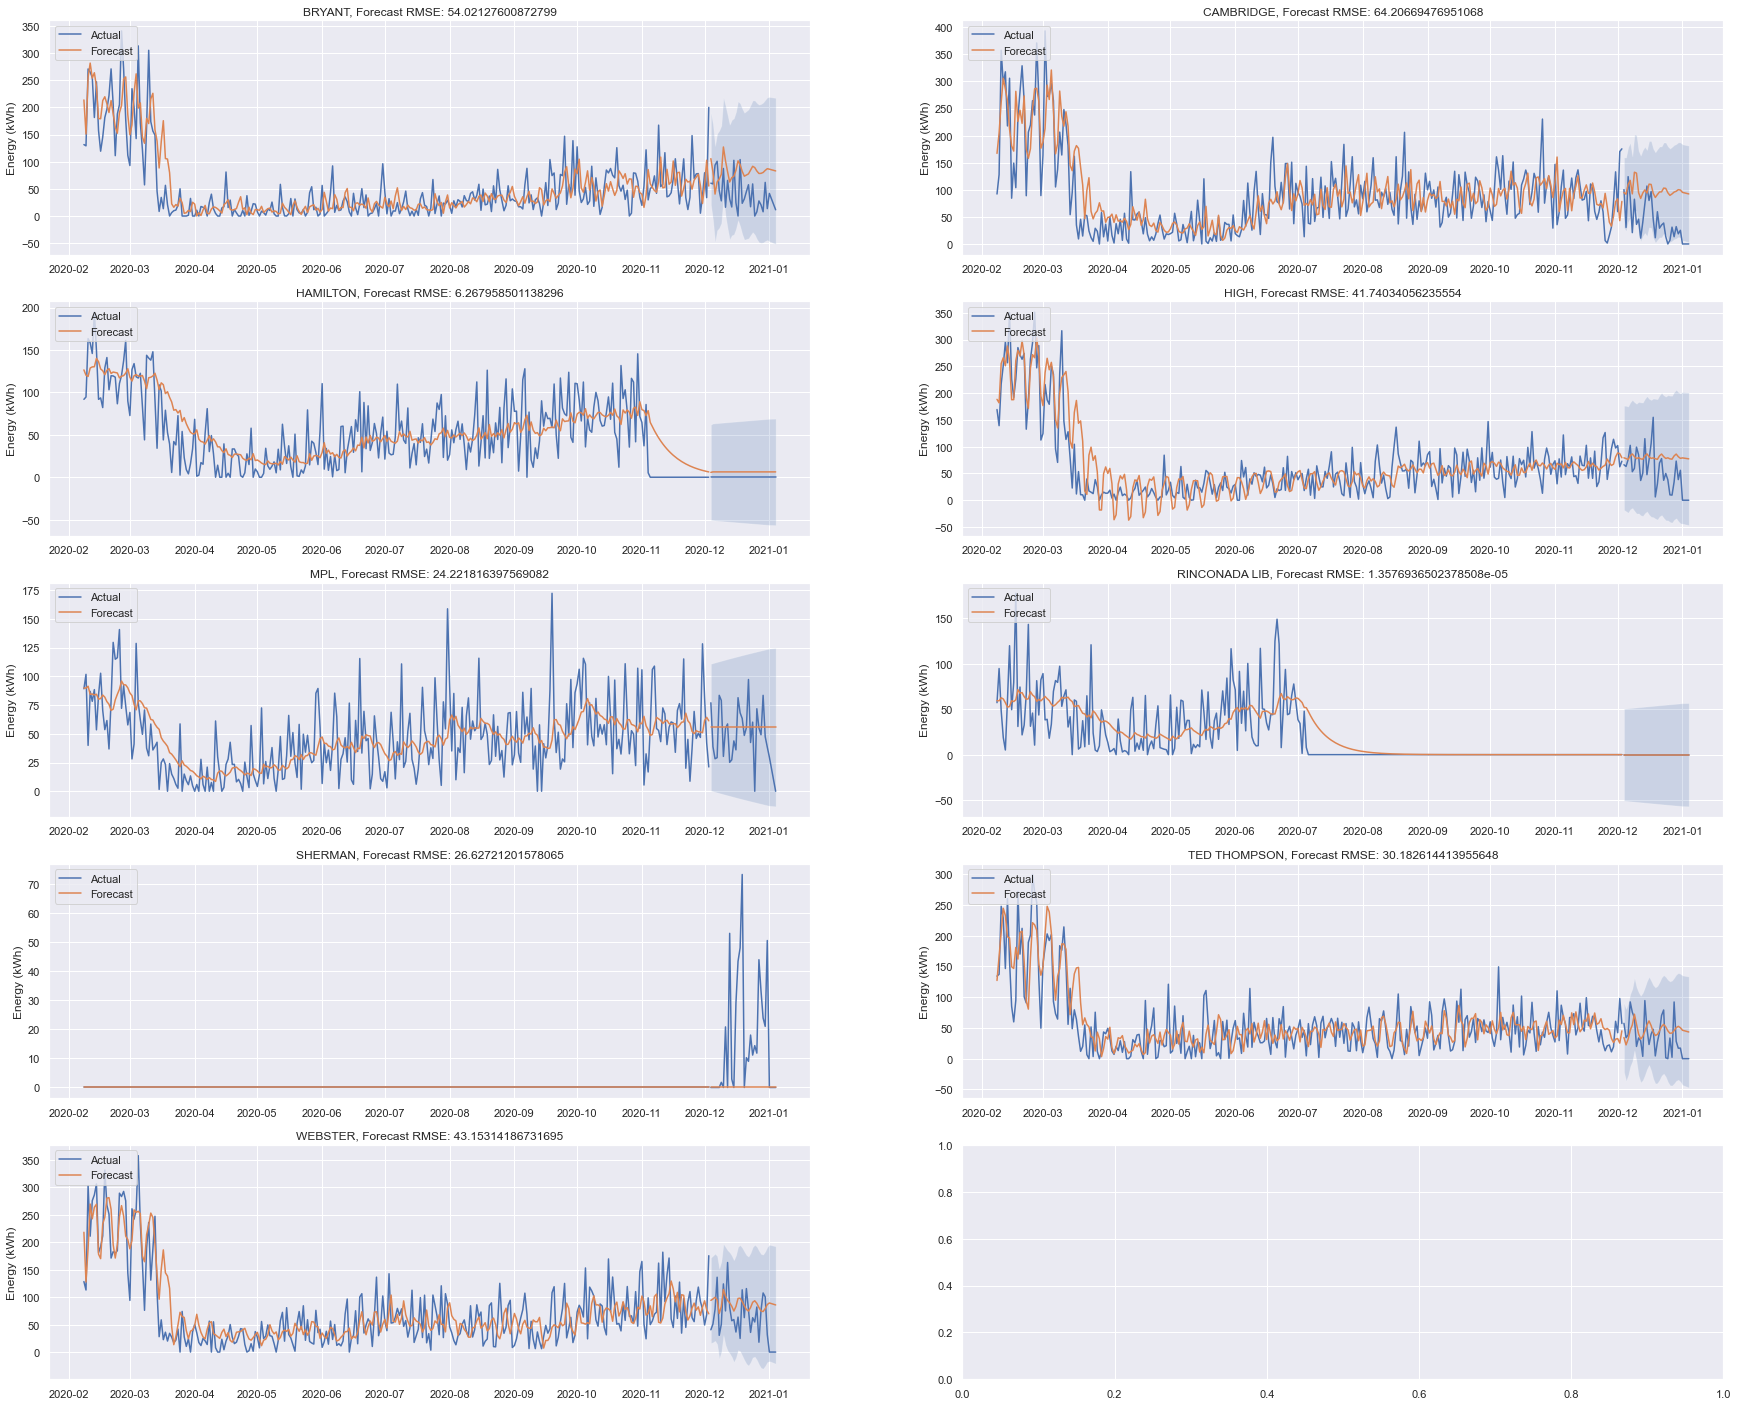

In [64]:
plotARIMAfunc(train_df_PA, test_df_PA, fit_df_PA, forecast_df_PA, lower_df_PA, upper_df_PA)

## Dundee

In [65]:
data_dundee = pd.read_csv('data/Dundee_merged.csv')

C:\Users\pgsva\AppData\Local\Temp\ipykernel_15248\1761076983.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dundee = pd.read_csv('data/Dundee_merged.csv')


In [66]:
data_dundee = data_dundee.assign(timestamp=pd.to_datetime(data_dundee["End Date"]).dt.date)
data_dundee = data_dundee[["timestamp", "Address 1", "Energy(kWh)"]].groupby(["timestamp", "Address 1"], as_index=False).sum()
data_dundee = pd.pivot_table(data_dundee, values="Energy(kWh)", index="timestamp", columns= "Address 1", aggfunc=np.sum, fill_value=0)
data_dundee.reset_index(inplace=True)

In [67]:
data_dundee.head(10)

Address 1   timestamp  ***TEST SITE*** Charge Your Car HQ  \
0          1970-01-01                                 0.0   
1          2017-09-01                                 0.0   
2          2017-09-02                                 0.0   
3          2017-09-03                                 0.0   
4          2017-09-04                                 0.0   
5          2017-09-05                                 0.0   
6          2017-09-06                                 0.0   
7          2017-09-07                                 0.0   
8          2017-09-08                                 0.0   
9          2017-09-09                                 0.0   

Address 1  Ardler Complex, Dundee  Balunie Drive, Dundee  \
0                            0.00                   0.00   
1                            0.00                   2.08   
2                            0.00                  47.17   
3                            0.00                  30.94   
4                            0.00                  23.19   
5                            0.00                  22.27   
6                            0.00                  47.46   
7                            0.00                   0.00   
8                            7.21                  26.97   
9                            0.00                  25.24   

Address 1  Brington Place Sheltered Housing, Dundee  \
0                                              0.00   
1                                             14.06   
2                                              7.69   
3                                            -10.46   
4                                             18.50   
5                                             12.44   
6                                             11.67   
7                                             19.10   
8                                              8.42   
9                                              9.46   

Address 1  DCC Environment, 34 Harefield Road  Dock Street, Dundee  \
0                                        0.00                0.000   
1                                        1.36                7.623   
2                                       11.17               36.744   
3                                        0.00                9.593   
4                                       20.75               16.714   
5                                        4.03               17.464   
6                                       12.08               15.542   
7                                        0.00               19.081   
8                                       11.81               16.365   
9                                       15.33                5.485   

Address 1  Dundee House, Dundee  Dundee Ice Arena, Dundee  \
0                          0.00                     0.000   
1                          5.72                   245.582   
2                          0.00                   340.500   
3                          0.00                   269.280   
4                         13.98                   186.840   
5                         24.21                   221.061   
6                         37.35                   295.905   
7                         34.98                   297.950   
8                         28.42                   330.680   
9                          0.00                   319.501   

Address 1  Earn Cresent, Dundee  ...  Sinclair Street  \
0                          0.00  ...            0.000   
1                          0.00  ...            2.551   
2                         15.13  ...           20.024   
3                          0.00  ...           21.638   
4                          0.00  ...           13.448   
5                          0.00  ...            0.563   
6                         10.96  ...            7.973   
7                          9.54  ...           18.134   
8                         45.88  ...           17.007   
9                         10.12  ...            

In [68]:
print(data_dundee[data_dundee == 0].count(axis=0)/len(data_dundee.index))

Address 1
timestamp                                        0.000000
***TEST SITE*** Charge Your Car HQ               0.965241
Ardler Complex, Dundee                           0.780749
Balunie Drive, Dundee                            0.259358
Brington Place Sheltered Housing, Dundee         0.042781
DCC Environment, 34 Harefield Road               0.655080
Dock Street, Dundee                              0.050802
Dundee House, Dundee                             0.296791
Dundee Ice Arena, Dundee                         0.093583
Earn Cresent, Dundee                             0.748663
Gellatly Street Car Park, Dundee                 0.008021
Greenmarket Multi Car Park, Dundee               0.010695
Housing Office East, Dundee                      0.165775
Housing Office West, Dundee                      0.165775
Janet Brougham House, Dundee                     0.427807
Lochee Charging Hub, Dundee                      0.596257
Marchbanks, Dundee                               0.216578
Menz

In [69]:
train_df_dundee, test_df_dundee, fit_df_dundee, forecast_df_dundee, lower_df_dundee, upper_df_dundee = autoARIMAfunc(data_dundee)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4037.793, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3628.415, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3769.824, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4044.992, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3525.384, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3525.115, Time=0.26 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3493.546, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3482.337, Time=0.29 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=3484.088, Time=0.35 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3484.143, Time=0.55 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3484.971, Time=0.69 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=3485.823, Time=1.14 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3482.625, Time=0.21 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 4.318 seconds
Performing stepwise se

RMSE for ***TEST SITE*** Charge Your Car HQ Stations: 13.72907031779763
RMSE for Ardler Complex, Dundee Stations: 8.685406417161747
RMSE for Balunie Drive, Dundee Stations: 14.431368470096057
RMSE for Brington Place Sheltered Housing, Dundee Stations: 5.032932687422627
RMSE for DCC Environment, 34 Harefield Road Stations: 3.2930921132329536e-05
RMSE for Dock Street, Dundee Stations: 21.02145175602944
RMSE for Dundee House, Dundee Stations: 266.8385088781542
RMSE for Dundee Ice Arena, Dundee Stations: 101.82604186357524
RMSE for Earn Cresent, Dundee Stations: 0.06286407814376119
RMSE for Gellatly Street Car Park, Dundee Stations: 26.465802611983094
RMSE for Greenmarket Multi Car Park, Dundee Stations: 42.85239838509775
RMSE for Housing Office East, Dundee Stations: 18.487433778364913
RMSE for Housing Office West, Dundee Stations: 10.687982771081426
RMSE for Janet Brougham House, Dundee Stations: 4.972380071165433e-05
RMSE for Lochee Charging Hub, Dundee Stations: 266.53964299479054
RMSE

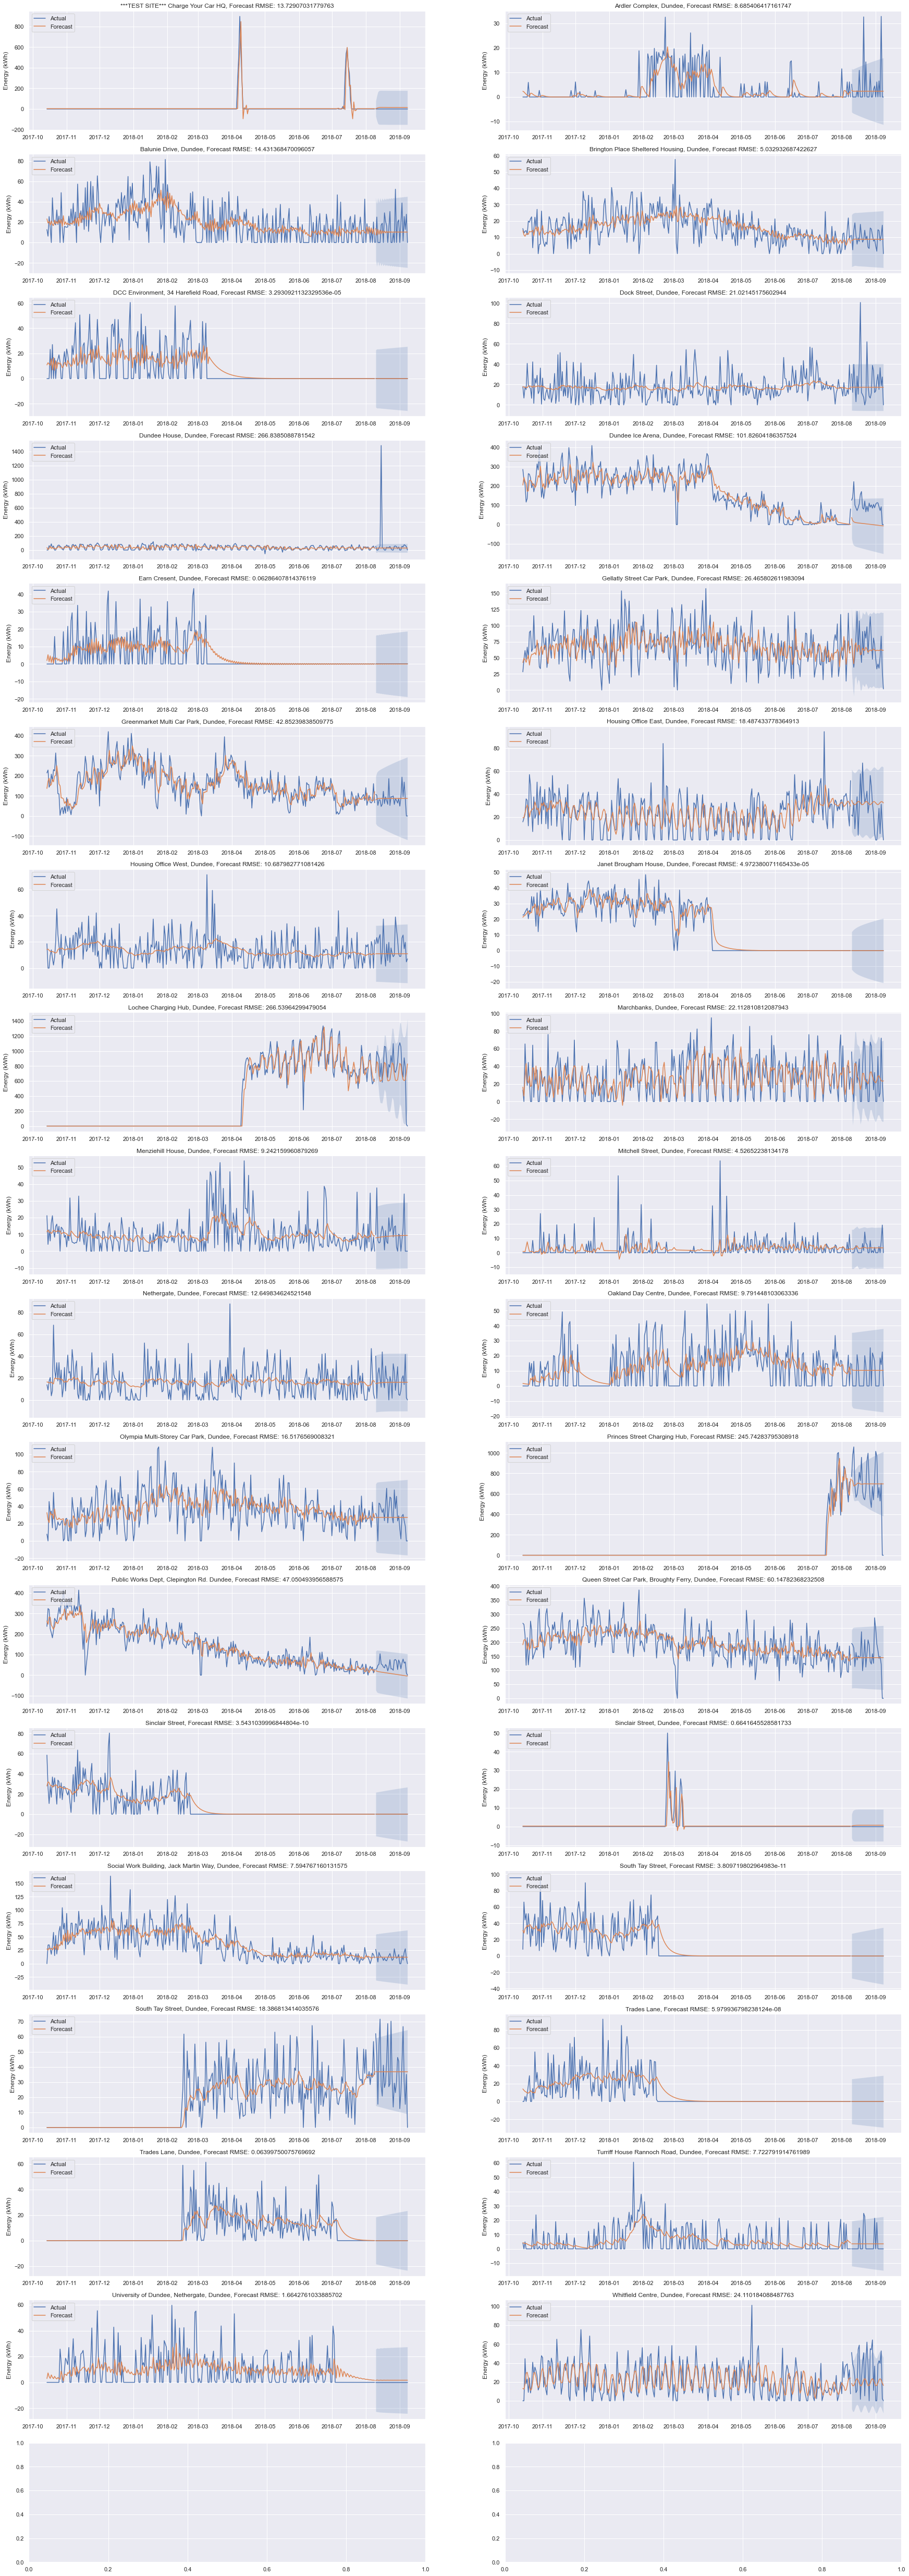

In [70]:
plotARIMAfunc(train_df_dundee, test_df_dundee, fit_df_dundee, forecast_df_dundee, lower_df_dundee, upper_df_dundee)

## Perth

In [71]:
df_1 = pd.read_csv('data/EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv', index_col=[0]).drop(columns=['OBJECTID'])
df_2 = pd.read_csv('data/EVChargeStationUseSept2017toAug2018.csv', index_col=[0])
df_3 = pd.read_csv('data/EVChargeStationUseSept2018toAug2019.csv', index_col=[0])

df_1 = df_1[df_1['Site'] != '***TEST SITE*** Charge Your Car HQ']
df_3 = df_3[df_3['Site'] != '***TEST SITE*** Charge Your Car HQ']

In [72]:

# Define a mapping dictionary for renaming
rename_mapping = {
    'King Street Car Park, Crieff': 'King Street Car Park',
    'Broxden Park & Ride, Perth': 'Broxden Park & Ride',
    'Canal Street Car Park 3rd floor, Perth': 'Canal Street Car Park',
    'Canal Street Car Park 3rd floor ': 'Canal Street Car Park',
    'Friarton Depot, Perth': 'Friarton Depot',
    'South Inch Car Park, Perth': 'South Inch Car Park',
    'Kinross Park and Ride, Kinross': 'Kinross Park and Ride',
    ' Leslie Street Car Park, Blairgowrie': 'Leslie Street Car Park, Blairgowrie',
}

# Replace the values in the 'Site' column using the mapping
df_1['Site'] = df_1['Site'].replace(rename_mapping)
df_2['Site'] = df_2['Site'].replace(rename_mapping)
df_3['Site'] = df_3['Site'].replace(rename_mapping)

df_1 = df_1.rename(columns={
    'CP_ID': 'CP ID',
    'Start_Date': 'Start Date',
    'Start_Time': 'Start Time',
    'End_Date': 'End Date',
    'End_Time': 'End Time',
    'Total_kWh': 'Total kWh'
})

# Union data
data_perth = pd.concat([df_1, df_2, df_3]).drop_duplicates()

# Drop records with below 0 Total kWh
data_perth = data_perth[data_perth['Total kWh'] >= 0]

# Drop two stations (too little data)
data_perth = data_perth[data_perth['Site'] != 'Market Square Alyth']
data_perth = data_perth[data_perth['Site'] != 'Mill Street, Perth']

In [73]:
data_perth.head()

CP ID  Connector           Start Date Start Time             End Date  \
_id                                                                          
1    51519          2  2017/08/31 00:00:00   22:12:00  2017/08/31 00:00:00   
2    51250          1  2017/08/31 00:00:00   22:01:00  2017/08/31 00:00:00   
3    50575          2  2017/08/31 00:00:00   21:21:00  2017/08/31 00:00:00   
4    51516          2  2017/08/31 00:00:00   20:43:00  2017/08/31 00:00:00   
5    50994          2  2017/08/31 00:00:00   19:50:00  2017/08/31 00:00:00   

     End Time  Total kWh                                   Site  \
_id                                                               
1    23:11:00      18.27                    Broxden Park & Ride   
2    22:31:00      19.45  Crown Inn Wynd Car Park, Auchterarder   
3    21:59:00      19.71                    South Inch Car Park   
4    21:03:00       9.84                  Kinross Park and Ride   
5    20:50:00      14.17    Leslie Street Car Park, Blairgowrie   

                            Model  
_id                                
1        APT Triple Rapid Charger  
2    Siemens Triple Rapid Charger  
3        APT Triple Rapid Charger  
4        APT Triple Rapid Charger  
5        APT Triple Rapid Charger

In [74]:
data_perth = data_perth.assign(timestamp=pd.to_datetime(data_perth["Start Date"]).dt.date)
data_perth = data_perth[["timestamp", "Site", "Total kWh"]].groupby(["timestamp", "Site"], as_index=False).sum()
data_perth = pd.pivot_table(data_perth, values="Total kWh", index="timestamp", columns= "Site", aggfunc=np.sum, fill_value=0)
data_perth.reset_index(inplace=True)

In [75]:
data_perth

Site   timestamp  Atholl Street Car Park, Dunkeld  Broxden Park & Ride  \
0     2016-01-09                            0.000              111.820   
1     2016-01-10                            0.000              134.360   
2     2016-01-11                            0.000               90.670   
3     2016-01-12                            0.000              105.014   
4     2016-02-09                            0.000               59.211   
...          ...                              ...                  ...   
1090  2019-12-04                           39.174              198.414   
1091  2019-12-05                           59.682              107.571   
1092  2019-12-06                           29.338              189.394   
1093  2019-12-07                           15.440              342.782   
1094  2019-12-08                           67.789              227.317   

Site  Canal Street Car Park  Crown Inn Wynd Car Park, Auchterarder  \
0                     0.000                                  0.000   
1                     0.000                                  0.380   
2                     0.000                                  0.000   
3                     0.000                                  0.000   
4                     0.000                                  5.820   
...                     ...                                    ...   
1090                 10.064                                 35.979   
1091                  0.000                                 49.180   
1092                 50.008                                 73.523   
1093                 30.845                                 55.829   
1094                 37.519                                112.902   

Site  Friarton Depot  King Street Car Park  Kinross Park and Ride  \
0             35.370                 0.000                 42.435   
1              0.000                25.172                 83.798   
2             35.930               100.149                 68.370   
3             45.780                 4.030                134.090   
4              0.000                 0.000                 56.630   
...              ...                   ...                    ...   
1090          47.753                31.058                116.072   
1091           0.000                83.894                236.344   
1092          72.499                72.792                263.845   
1093          20.380                33.170                227.842   
1094          34.740               106.708                295.120   

Site  Leslie Street Car Park, Blairgowrie  Moness Terrace Car Park, Aberfeldy  \
0                                  13.234                               0.000   
1                                   0.000                              42.324   
2                                  35.475                               0.000   
3                                  61.890                               6.800   
4                                   9.540                               0.000   
...                                   ...                                 ...   
1090                                0.000                              90.670   
1091                                5.822                             149.029   
1092                               29.646                              38.923   
1093                                8.430                              84.198   
1094                               59.715                              55.391   

Site  Rie-Achan Road Car Park, Pitlochry  South Inch Car Park  
0                                 40.436               23.946  
1                                 44.970               43.408  
2                                 19.590               35.115  
3                                 20.240               10.278  
4                                 18.610               36.482  
...                                  ...                  ...  
1090                

In [76]:
print(data_perth[data_perth == 0].count(axis=0)/len(data_perth.index))

Site
timestamp                                0.000000
Atholl Street Car Park, Dunkeld          0.369863
Broxden Park & Ride                      0.000000
Canal Street Car Park                    0.187215
Crown Inn Wynd Car Park, Auchterarder    0.103196
Friarton Depot                           0.210959
King Street Car Park                     0.053881
Kinross Park and Ride                    0.003653
Leslie Street Car Park, Blairgowrie      0.075799
Moness Terrace Car Park, Aberfeldy       0.136986
Rie-Achan Road Car Park, Pitlochry       0.037443
South Inch Car Park                      0.008219
dtype: float64


In [77]:
train_df_perth, test_df_perth, fit_df_perth, forecast_df_perth, lower_df_perth, upper_df_perth = autoARIMAfunc(data_perth)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10030.742, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9811.805, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9518.750, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10028.747, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9493.592, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9494.064, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9495.736, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9688.353, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9495.704, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9495.701, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.232 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12032.604, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11765

RMSE for Atholl Street Car Park, Dunkeld Stations: 57.56484821375761
RMSE for Broxden Park & Ride Stations: 72.02142375123651
RMSE for Canal Street Car Park Stations: 21.910401718878102
RMSE for Crown Inn Wynd Car Park, Auchterarder Stations: 34.11999425969723
RMSE for Friarton Depot Stations: 19.21460844219384
RMSE for King Street Car Park Stations: 36.018682504483664
RMSE for Kinross Park and Ride Stations: 61.77410729734898
RMSE for Leslie Street Car Park, Blairgowrie Stations: 38.43702496064899
RMSE for Moness Terrace Car Park, Aberfeldy Stations: 37.22802828762869
RMSE for Rie-Achan Road Car Park, Pitlochry Stations: 50.55069573338147
RMSE for South Inch Car Park Stations: 40.86241878616647


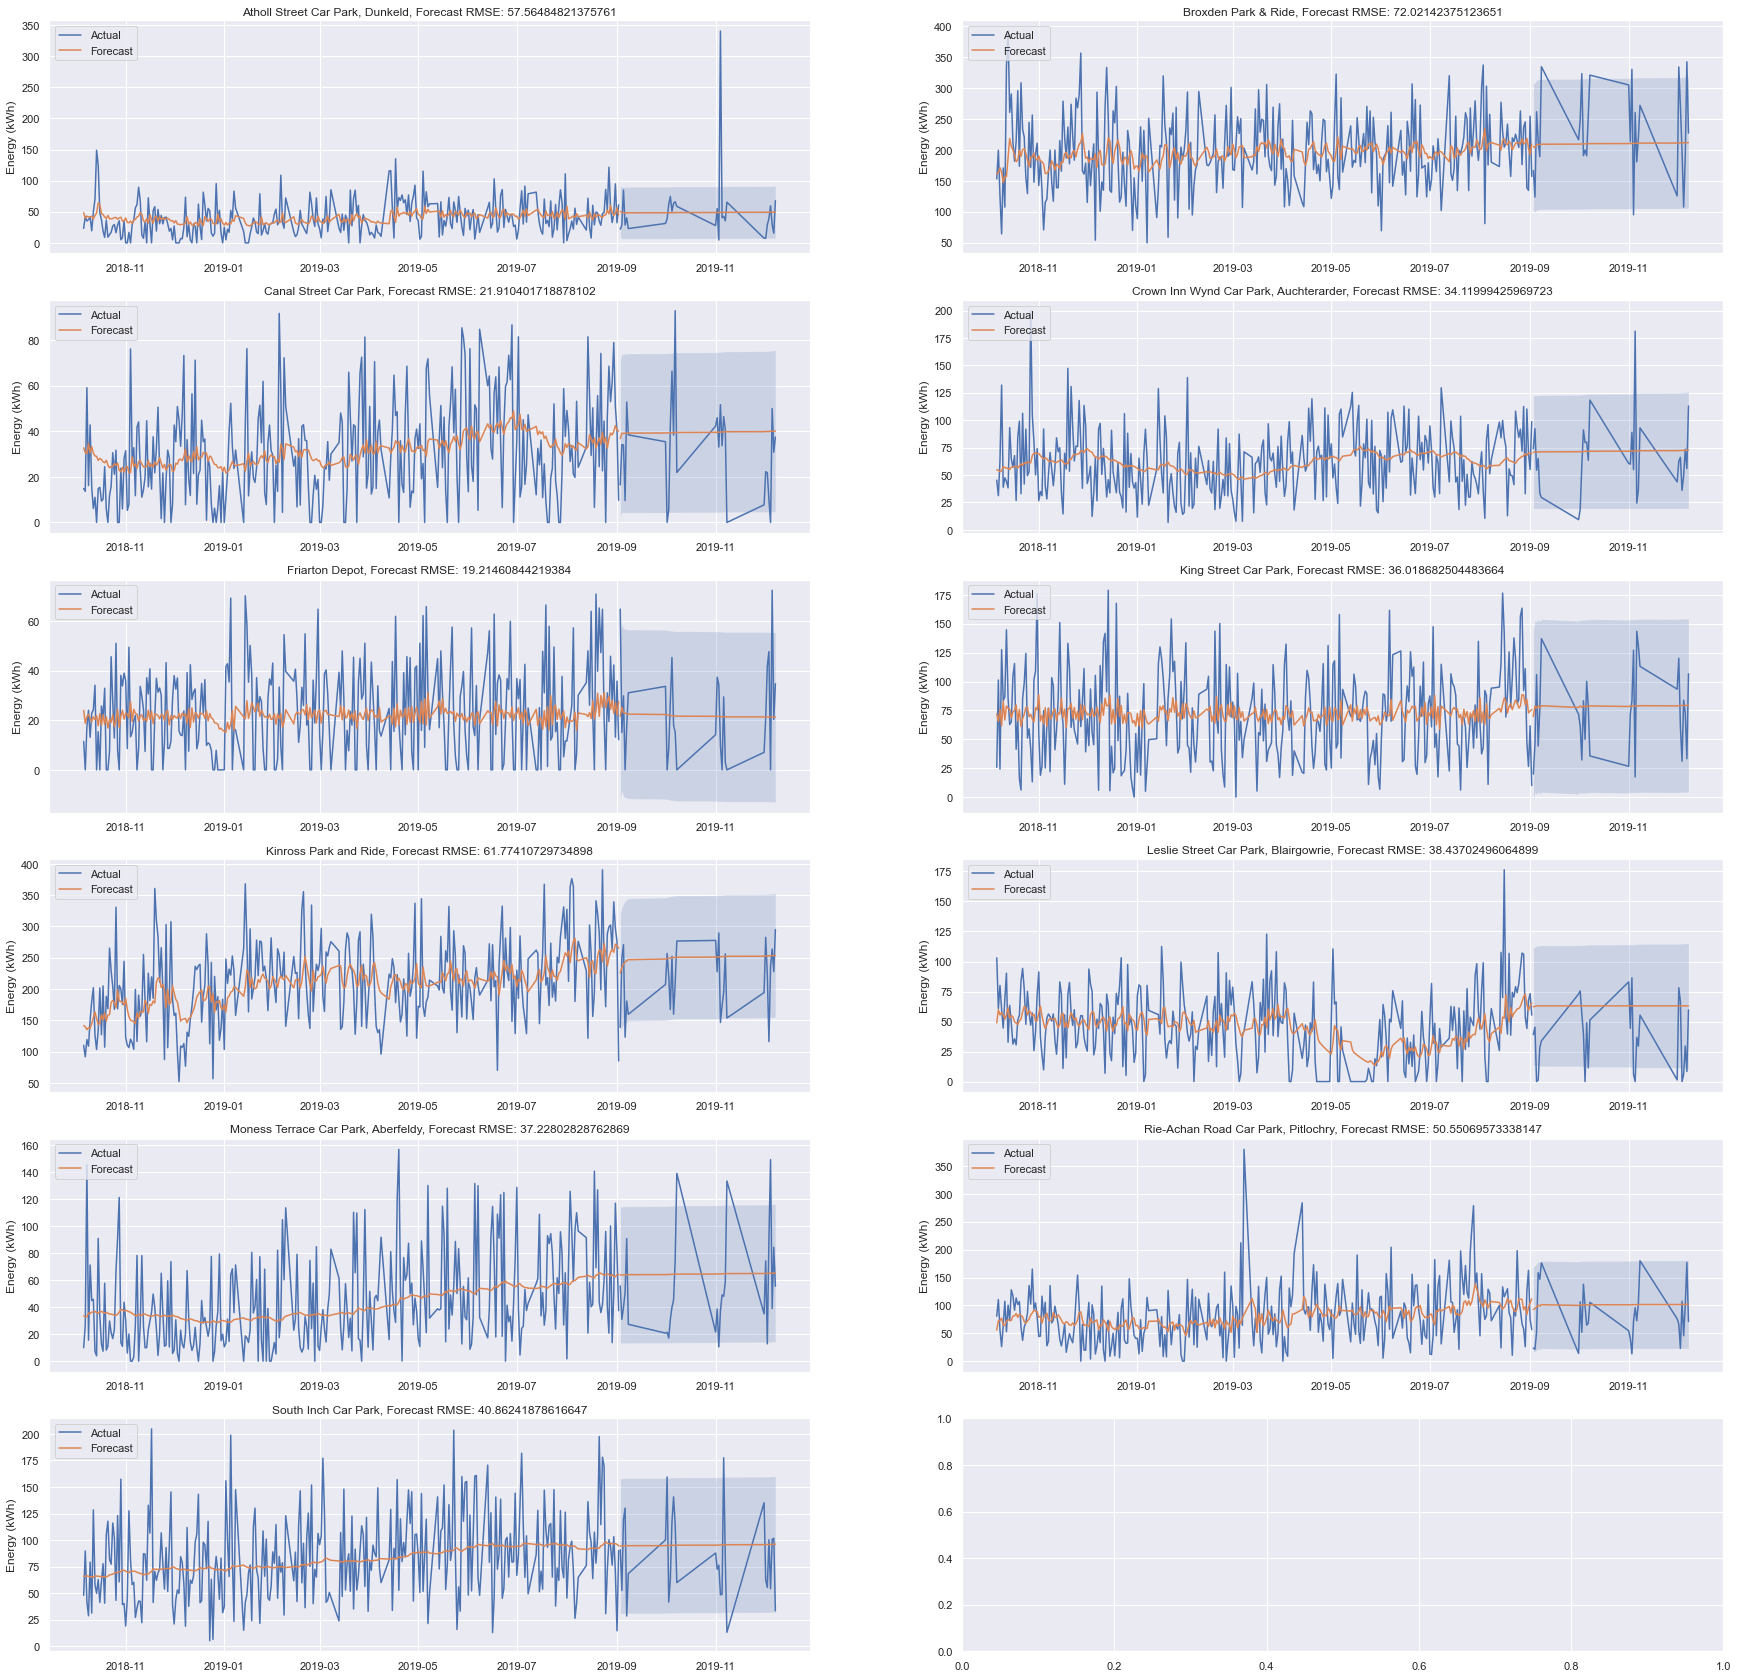

In [78]:
plotARIMAfunc(train_df_perth, test_df_perth, fit_df_perth, forecast_df_perth, lower_df_perth, upper_df_perth)